# Fraud in Mobile Money Transactions
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

# Libraries

In [1]:
#installing a new library
!pip install outlier_utils

In [2]:
!pip install imbalanced-learn 
# sudo pip install imbalanced-learn (macos/linux)
# pip install delayed (only do this if required)

In [3]:
# allows us to ignore warnings, since they are just warnings 
import warnings
warnings.filterwarnings('ignore')

# allows us to print things in jupyter in a pretty way
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# import pandas to be able to use dataframes
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# import plotting library
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# allow inline plotting on notebook cells
%matplotlib inline
plt.switch_backend('agg')

# we'll get access to the numpy library
import numpy as np

# We'll use a label encoder to convert categorical feature to numerical values
from sklearn.preprocessing import LabelEncoder

# install using: pip install outlier_utils
# univariate anomaly detection
from outliers import smirnov_grubbs as grubbs

# Access to the localoutlierfactor for clustering
from sklearn.neighbors import LocalOutlierFactor

# allows us to implement a train test split strategy
from sklearn.model_selection import train_test_split

# access to the logistic regression class of Sklearn
from sklearn.linear_model import LogisticRegression

# access to the neural network model MLP Classifier
from sklearn.neural_network import MLPClassifier

# classification metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# for use with CAP report
from scipy import integrate

# feature power transformation functions
from scipy.stats import boxcox
from scipy.special import boxcox1p

# normality tests
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import probplot

# pip install imbalanced-learn (open anaconda prompt as admin)
# sudo pip install imbalanced-learn (macos/linux)
# pip install delayed (only do this if required)
# This module is used for handling imbalanced data
from imblearn.over_sampling import SMOTE

# Collections is a core python module. We wille use counter only for reporting
from collections import Counter




In [4]:
# allows us to ignore warnings, since they are just warnings 
import warnings
warnings.filterwarnings('ignore')

# allows us to print things in jupyter in a pretty way
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# import pandas to be able to use dataframes
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# import plotting library
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# allow inline plotting on notebook cells
%matplotlib inline

# we'll get access to the numpy library
import numpy as np

# We'll use a label encoder to convert categorical feature to numerical values
from sklearn.preprocessing import LabelEncoder

# install using: pip install outlier_utils
# univariate anomaly detection
from outliers import smirnov_grubbs as grubbs

# Access to the localoutlierfactor for clustering
from sklearn.neighbors import LocalOutlierFactor

# allows us to implement a train test split strategy
from sklearn.model_selection import train_test_split

# access to the logistic regression class of Sklearn
from sklearn.linear_model import LogisticRegression

# access to the neural network model MLP Classifier
from sklearn.neural_network import MLPClassifier

# classification metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# feature power transformation functions
from scipy.stats import boxcox
from scipy.special import boxcox1p

# normality tests
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import probplot


# Exploration

In [5]:
# https://www.kaggle.com/ntnu-testimon/paysim1/download
# https://www.kaggle.com/datasets/ealaxi/paysim1
# download archive.zip file and place in data/ folder 

data_df = pd.read_csv('data/archive.zip')

In [6]:
data_df.shape

(6362620, 11)

In [7]:
# Let's fix some of the columns 
data_df = data_df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

# Header
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [8]:
# Let's have a quick view of the dataset
tmp_df = data_df.head(1).T
tmp_df.columns = ['sample']
tmp_df['dtypes'] = data_df.dtypes
tmp_df

,sample,dtypes
step,1,int64
type,PAYMENT,object
amount,9839.640000,float64
nameOrig,C1231006815,object
oldBalanceOrig,170136.000000,float64
newBalanceOrig,160296.360000,float64
nameDest,M1979787155,object
oldBalanceDest,0.000000,float64
newBalanceDest,0.000000,float64
isFraud,0,int64


In [9]:
# Do we have rows that have any null values?
data_df.isnull().values.any()

False

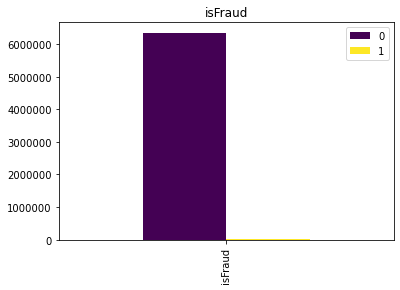

In [10]:
col = 'isFraud'
series = data_df[col]
tmp_df = pd.DataFrame(series.value_counts())
tmp_df = tmp_df.T


tmp_df.plot.bar(title=col,cmap="viridis")
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.show()

In [11]:
# There is a large imbalance between the two classes
display(tmp_df)

,0,1
isFraud,6354407,8213


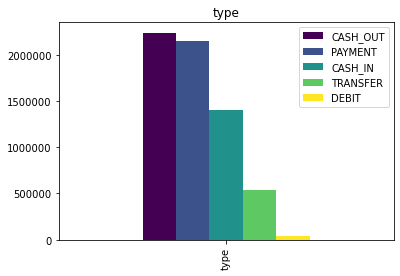

In [12]:
# Let's try to better understand our data

col = 'type'
series = data_df[col]
tmp_df = pd.DataFrame(series.value_counts())
tmp_df = tmp_df.T


tmp_df.plot.bar(title=col,cmap="viridis")
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.show()

In [13]:
tmp_df = data_df['amount']
tmp_df.describe()

count    6362620.000000
mean      179861.903549
std       603858.231463
min            0.000000
25%        13389.570000
50%        74871.940000
75%       208721.477500
max     92445516.640000
Name: amount, dtype: float64

<AxesSubplot:>

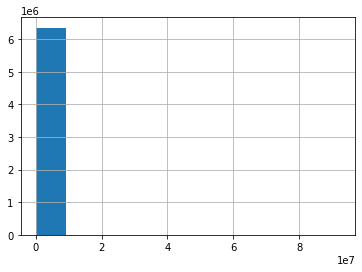

In [14]:
tmp_df.hist()

In [15]:
# Looking further into payment type

In [16]:
#for each payment type, this function display summary statistics for amount, count of fraud cases and 
#origin vs destination (regular vs merchant)

col = 'type'
tmp_s = data_df[col]
tmp_list = tmp_s.unique()

for i in tmp_list:
    printmd("***"+i+"***")
    
    tmp_df = data_df[data_df['type']==i]
    display(tmp_df.describe()[['amount']].T)
    
    # fraud
    display(pd.DataFrame(tmp_df['isFraud'].value_counts()))
    
    # merchant vs regular customer
    
    # origin
    
    orig = {'regular': tmp_df[tmp_df.nameOrig.str.contains('C')].drop_duplicates().shape[0], 
             'merchant': tmp_df[tmp_df.nameOrig.str.contains('M')].drop_duplicates().shape[0]}
    dest = {'regular': tmp_df[tmp_df.nameDest.str.contains('C')].drop_duplicates().shape[0], 
             'merchant': tmp_df[tmp_df.nameDest.str.contains('M')].drop_duplicates().shape[0]}
    
    txn = [orig, dest]
    
    txn_df = pd.DataFrame(txn)
    txn_df.index = ["orig","dest"]
    
    display(txn_df)
  

***PAYMENT***

,count,mean,std,min,25%,50%,75%,max
amount,2151495.000000,13057.604660,12556.450186,0.020000,4383.820000,9482.190000,17561.220000,238637.980000


,isFraud
0,2151495


,regular,merchant
orig,2151495,0
dest,0,2151495


***TRANSFER***

,count,mean,std,min,25%,50%,75%,max
amount,532909.000000,910647.009645,1879573.528908,2.600000,215905.350000,486308.390000,974958.000000,92445516.640000


,isFraud
0,528812
1,4097


,regular,merchant
orig,532909,0
dest,532909,0


***CASH_OUT***

,count,mean,std,min,25%,50%,75%,max
amount,2237500.000000,176273.964346,175329.744483,0.000000,72669.650000,147072.185000,246539.477500,10000000.000000


,isFraud
0,2233384
1,4116


,regular,merchant
orig,2237500,0
dest,2237500,0


***DEBIT***

,count,mean,std,min,25%,50%,75%,max
amount,41432.000000,5483.665314,13318.535518,0.550000,1500.180000,3048.990000,5479.175000,569077.510000


,isFraud
0,41432


,regular,merchant
orig,41432,0
dest,41432,0


***CASH_IN***

,count,mean,std,min,25%,50%,75%,max
amount,1399284.000000,168920.242004,126508.255272,0.040000,70510.182500,143427.710000,239899.087500,1915267.900000


,isFraud
0,1399284


,regular,merchant
orig,1399284,0
dest,1399284,0


Looks like most frauds occured in Transfer and cash out and with regular customers

In [17]:
# Let's look at consistency of balance within transactions before and after

# this should result to zero for a balanced transaction
data_df['errorOrig'] = (data_df['newBalanceOrig']+data_df['amount'])-data_df['oldBalanceOrig']
data_df['errorDest'] = (data_df['oldBalanceDest']+data_df['amount'])-data_df['newBalanceDest']

# what is the percentage of transactions with non-balanced (non ZERO) transactions?
print("% of orig txns with non zero error balance: ",data_df[data_df['errorOrig']!=0]['errorOrig'].count()/data_df['errorOrig'].shape[0])
print("% of dest txns with non zero error balance: ",data_df[data_df['errorDest']!=0]['errorDest'].count()/data_df['errorDest'].shape[0])

# how does it look like broken down by payment types?
print()
print("% of orig txns w/ non zero error balance by payment type")
tmp_df = data_df[data_df['errorOrig']!=0].groupby(['type']).count()['errorOrig']/data_df.groupby(['type']).count()['errorOrig']
tmp_df = pd.DataFrame(tmp_df)
display(tmp_df)

print("% of dest txns w/ non zero error balance by payment type")
tmp_df = data_df[data_df['errorDest']!=0].groupby(['type']).count()['errorDest']/data_df.groupby(['type']).count()['errorDest']
tmp_df = pd.DataFrame(tmp_df)
display(tmp_df)

# what about by fraud indicator?
print("% of orig txns w/ non zero error balance by fraud ind")
tmp_df = data_df[data_df['errorOrig']!=0].groupby(['isFraud']).count()['errorOrig']/data_df.groupby(['isFraud']).count()['errorOrig']
tmp_df = pd.DataFrame(tmp_df)
display(tmp_df)

print("% of dest txns w/ non zero error balance by fraud ind")
tmp_df = data_df[data_df['errorDest']!=0].groupby(['isFraud']).count()['errorDest']/data_df.groupby(['isFraud']).count()['errorDest']
tmp_df = pd.DataFrame(tmp_df)
display(tmp_df)

% of orig txns with non zero error balance:  0.8192331146603129
% of dest txns with non zero error balance:  0.7444533855550072

% of orig txns w/ non zero error balance by payment type


,errorOrig
type,
CASH_IN,1.000000
CASH_OUT,0.898052
DEBIT,0.329962
PAYMENT,0.594509
TRANSFER,0.958963


% of dest txns w/ non zero error balance by payment type


,errorDest
type,
CASH_IN,1.000000
CASH_OUT,0.417347
DEBIT,0.475743
PAYMENT,1.000000
TRANSFER,0.436039


% of orig txns w/ non zero error balance by fraud ind


,errorOrig
isFraud,
0,0.820283
1,0.006940


% of dest txns w/ non zero error balance by fraud ind


,errorDest
isFraud,
0,0.744578
1,0.648241


It seems in general having non zero error balance between transactions does not indicate any fraud behavior except for destination accounts which has higher than normal of 64% identified as fraud

In [18]:
# how many unique fraud customers can be found in Cash out and transfer type transactions?
data_df.groupby(['isFraud','type']).nunique()[['nameOrig','nameDest']]

nameOrig  nameDest
isFraud type                        
0       CASH_IN    1398845    446789
        CASH_OUT   2232246    488215
        DEBIT        41432     38533
        PAYMENT    2150401   2150401
        TRANSFER    528744    233686
1       CASH_OUT      4116      4091
        TRANSFER      4097      4097

In [19]:
fraud_df = data_df[data_df['isFraud']==1]
notfraud_df = data_df[data_df['isFraud']==0]

In [20]:
# Are there any relationships within the customers and merchants that conducted fraud?

fraudorig_set = set(fraud_df['nameOrig'].values) #convert series to array then set (unique) 
frauddest_set = set(fraud_df['nameDest'].values) #convert series to array then set (unique)
fraudcombined_set = fraudorig_set.union(frauddest_set) #combine both into one set

notfraudorig_set = set(notfraud_df['nameOrig'].values) #convert series to array then set (unique) 
notfrauddest_set = set(notfraud_df['nameDest'].values) #convert series to array then set (unique)
notfraudcombined_set = notfraudorig_set.union(notfrauddest_set) #combine both into one set

In [21]:
print("Total unique customer count: ", len(fraudcombined_set.union(notfraudcombined_set)))
print("Customers involved in fraud: ",len(fraudcombined_set))
print("Customers NOT involved in fraud: ",len(notfraudcombined_set))
print("Originating Customers in Txns: ", len(fraudorig_set.union(notfraudorig_set)))
print("Destination Customers in Txns: ", len(frauddest_set.union(notfrauddest_set)))
print("Count of customers that originated in fraud transactions: ",len(fraudorig_set))
print("How many of those customers are regular customers? ",len([i for i in fraudorig_set if 'C' in i]))
print("How many of those customers are merchant customers? ", len([i for i in fraudorig_set if 'M' in i]))
print("Count of customers that is the destination in fraud transactions: ",len(frauddest_set))
print("How many of those customers are regular customers? ",len([i for i in frauddest_set if 'C' in i]))
print("How many of those customers are merchant customers? ", len([i for i in frauddest_set if 'M' in i]))
print("how many Fraud customers showed up in BOTH orig and dest? ", len(frauddest_set.intersection(fraudorig_set)))


Total unique customer count:  9073900
Customers involved in fraud:  16382
Customers NOT involved in fraud:  9063043
Originating Customers in Txns:  6353307
Destination Customers in Txns:  2722362
Count of customers that originated in fraud transactions:  8213
How many of those customers are regular customers?  8213
How many of those customers are merchant customers?  0
Count of customers that is the destination in fraud transactions:  8169
How many of those customers are regular customers?  8169
How many of those customers are merchant customers?  0
how many Fraud customers showed up in BOTH orig and dest?  0


In [22]:
print("Did any fraud orig customers show up in legitimate transactions? ")
print("How many transactions as originating customers? ", data_df[(data_df['nameOrig'].isin(fraudorig_set)) & (data_df['isFraud']==0)].shape[0])
print("How many unique ids showed up as originating customers: ", len(fraudorig_set.intersection(notfraudorig_set)))
print("How many transactions as destination customers? ", data_df[(data_df['nameDest'].isin(fraudorig_set)) & (data_df['isFraud']==0)].shape[0])
print("How many unique ids showed up as destination customers: ", len(fraudorig_set.intersection(notfrauddest_set)))
print("")
print("Did any fraud dest customers show up in legitimate transactions? ")
print("How many transactions as originating customers? ", data_df[(data_df['nameOrig'].isin(frauddest_set)) & (data_df['isFraud']==0)].shape[0])
print("How many unique ids showed up as originating customers: ", len(frauddest_set.intersection(notfraudorig_set)))
print("How many transactions as destination customers? ", data_df[(data_df['nameDest'].isin(frauddest_set)) & (data_df['isFraud']==0)].shape[0])
print("How many unique ids showed up as destination customers: ", len(frauddest_set.intersection(notfrauddest_set)))


Did any fraud orig customers show up in legitimate transactions? 
How many transactions as originating customers?  28
How many unique ids showed up as originating customers:  28
How many transactions as destination customers?  0
How many unique ids showed up as destination customers:  0

Did any fraud dest customers show up in legitimate transactions? 
How many transactions as originating customers?  18
How many unique ids showed up as originating customers:  18
How many transactions as destination customers?  57435
How many unique ids showed up as destination customers:  5492


In [23]:
tmp_df = pd.DataFrame()
tmp_df['fraud'] = fraud_df.amount.describe().T
tmp_df['notfraud'] = notfraud_df.amount.describe().T
display(tmp_df.T)

,count,mean,std,min,25%,50%,75%,max
fraud,8213.000000,1467967.299140,2404252.947240,0.000000,127091.330000,441423.440000,1517771.480000,10000000.000000
notfraud,6354407.000000,178197.041727,596236.981347,0.010000,13368.395000,74684.720000,208364.760000,92445516.640000


# Preprocessing

In [24]:
# do we still have any null values?
data_df.isnull().values.any()

False

In [25]:
enc = LabelEncoder()
data_df['type_num'] = enc.fit_transform(data_df['type'])
data_df['type_num'] = data_df['type_num'].apply(lambda x: np.int64(x))

In [26]:
# Let's remove the variables that we do not need

training_df = data_df.drop(['nameOrig','nameDest','isFlaggedFraud','type','step'], axis=1)


In [27]:
training_df.head()

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,errorOrig,errorDest,type_num
0,9839.640000,170136.000000,160296.360000,0.000000,0.000000,0,0.000000,9839.640000,3
1,1864.280000,21249.000000,19384.720000,0.000000,0.000000,0,0.000000,1864.280000,3
2,181.000000,181.000000,0.000000,0.000000,0.000000,1,0.000000,181.000000,4
3,181.000000,181.000000,0.000000,21182.000000,0.000000,1,0.000000,21363.000000,1
4,11668.140000,41554.000000,29885.860000,0.000000,0.000000,0,0.000000,11668.140000,3


In [28]:
training_df.dtypes

amount            float64
oldBalanceOrig    float64
newBalanceOrig    float64
oldBalanceDest    float64
newBalanceDest    float64
isFraud             int64
errorOrig         float64
errorDest         float64
type_num            int64
dtype: object

# Anomaly Detection
## via Clustering

Unsupervised Outlier Detection using Local Outlier Factor (LOF)

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

In [29]:
y = training_df.isFraud
X = training_df.drop(['isFraud'],axis=1)

In [30]:
%%time

lof_model = LocalOutlierFactor(n_neighbors=2)
y_pred = lof_model.fit_predict(X)




CPU times: user 48min 11s, sys: 18.8 s, total: 48min 30s
Wall time: 48min 33s


In [31]:
# lof works by tagging inliers with 1 and outliers by -1
y_pred

array([ 1,  1,  1, ...,  1,  1, -1])

In [32]:
# Let's see how many outliers our unsupervised model detected (outliers are tagged as -1)

tmp_df = pd.DataFrame(y_pred)
tmp_df.value_counts()

 1    5763320
-1     599300
dtype: int64

negative_outlier_factor_ is The opposite LOF of the training samples. The higher, the more normal. Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score.


In [33]:
lof_model.negative_outlier_factor_

array([-1.01172887, -1.26723534, -1.10111715, ..., -1.03842368,
       -1.41166573, -2.27082054])

You can think of the negative_outlier_factor_ as our indicator on how 'far' the outlier is from the neighborhood densities.

This demonstrates that we can use an unsupervised modeling approach to fraud detection in the event that we do not have yet substantial data on caught fraudsters. It is a good starting point to build our way towards building supervised models.

## via Grubb's Test

Grubbs’ Test is used to identify the presence of outliers in a dataset. To use this test, a dataset should be approximately normally distributed and have at least 7 observations. Grubbs's test is based on the assumption of **normality**. That is, one should first verify that the data can be reasonably approximated by a normal distribution before applying the Grubbs test.

https://en.wikipedia.org/wiki/Grubbs%27s_test

**For purposes of demonstration we will only use ONE FEATURE to show case the tests**

'Before'

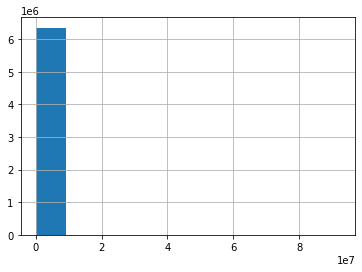

'After'

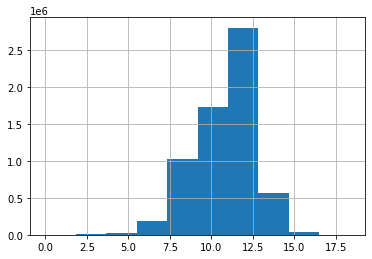

In [34]:
# we will look at two classes of techniques for checking whether a sample of data is Gaussian:

# Graphical Methods. These are methods for plotting the data and qualitatively evaluating whether the data looks Gaussian.
# Statistical Tests. These are methods that calculate statistics on the data and quantify how likely it is that
# the data was drawn from a Gaussian distribution. Methods of this type are often called normality tests.

# via Graphical - We assume that plotting our data set would result to what would look like a 'normal' distribution

# histogram - is an approximate representation of the distribution of numerical data

series_tmp = training_df['amount'].copy()
display("Before")
series_tmp.hist()
plt.show()
# you can see here that our distribution skews to the left which is different to the bellcurve of a normal/gaussian distribution

# To address this, we use a power transformation and try to make our dataset look normal/gaussian
# The Boxcox function accepts a lambda parameter that dictates what transformation to do
# In this case a lambda value of 0 means it will do a log transformation to all of the data set
boxcox_series_tmp = pd.Series(boxcox1p(series_tmp,0))
display("After")
boxcox_series_tmp.hist()
plt.show()

# You can see here that our data set is now more 'gaussian' like

'Before'

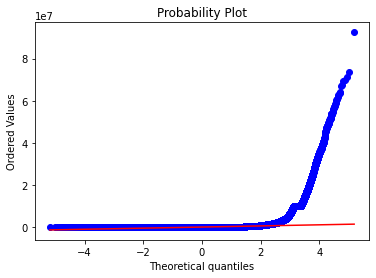

'After'

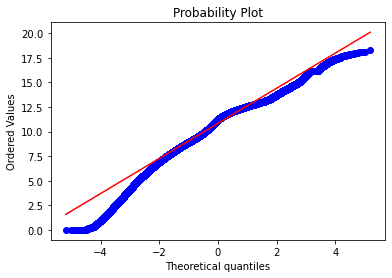

In [35]:
# The Q-Q plot, or quantile-quantile plot, is a graphical tool to help us assess if
# a set of data plausibly came from some theoretical distribution such as a Normal or exponential. 

display("Before")
probplot(series_tmp, dist="norm", plot=plt)
plt.show()

# You can see that our data set does not completely fit our plot, so we apply the same power transformation

display("After")

probplot(boxcox_series_tmp, dist="norm", plot=plt)
plt.show()

# We plot the data set again and see a minor visual improvements to the qq plot


In [36]:
# The next tests validate by generating a statistic called p value 
# Technically this is called the null hypothesis, or H0. A threshold level is chosen called alpha, 
# typically 5% (or 0.05), that is used to interpret the p-value.

# In the SciPy implementation of these tests, you can interpret the p value as follows.

# p <= alpha: reject H0, not normal.
# p > alpha: fail to reject H0, normal.



print("Using Shapiro Normality Test")
print("Before: ")
print(shapiro(series_tmp))

print("After")
print(shapiro(boxcox_series_tmp))

# The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a
# Gaussian distribution, named for Samuel Shapiro and Martin Wilk.

print("")

print("Using D’Agostino’s K^2 Normality Test")
print("Before: ")
print(normaltest(series_tmp))

print("After")
print(normaltest(boxcox_series_tmp))


# The normal test AKA D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness,
# to determine if the data distribution departs from the normal distribution, named for Ralph D’Agostino.

Using Shapiro Normality Test
Before: 
ShapiroResult(statistic=0.19261687994003296, pvalue=0.0)
After
ShapiroResult(statistic=0.8985119462013245, pvalue=0.0)

Using D’Agostino’s K^2 Normality Test
Before: 
NormaltestResult(statistic=16762631.767949674, pvalue=0.0)
After
NormaltestResult(statistic=293476.98081797117, pvalue=0.0)


Our statistical tests are telling us that our data set it not normally distributed, because of the resulting pvalue below .05 threshold despite our power transformations. On the other hand our graphical tests tells us that our data after the transformations are a bit more gaussian /normal like. No tests are perfect as well as no data is in reality 'completely' normally distributed. We can use this as decision point to move forward and treat our data set as gaussian like.

In [37]:
# test for normality first
# transform to normal / guassian distribution to fit  if normality test fails
# run grubb's test



print("Our transformed data set length count: ")
print(len(boxcox_series_tmp))
grubbs_result = grubbs.test(boxcox_series_tmp, alpha=0.05)

print("Our Grubbs test result length count: ")
print(len(grubbs_result))

print("Grubs test works by returning the dataset and removing the anomalies, you can see that we returned missing 1, which means we found 1 anomaly")

Our transformed data set length count: 
6362620
Our Grubbs test result length count: 
6362619
Grubs test works by returning the dataset and removing the anomalies, you can see that we returned missing 1, which means we found 1 anomaly


In [38]:
# Let's look at what index was dropped by the test 
set(list(boxcox_series_tmp.index)).difference(set(list(grubbs_result.index)))

{2736447}

In [39]:
# what value did the test consider as outlier?
boxcox_series_tmp[2736447]

0.0

# SMOTE for oversampling
SMOTE stands for Synthetic Minority Oversampling Technique. This is a statistical technique for increasing the number of cases in your dataset in a balanced way.

Since our fraud dataset is imbalanced (low fraud cases), we will use oversampling to try to 'balance' the classes. This will results to more robust trained models that would be less prone to under or overfitting due to under or over representation.

In [40]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [41]:
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 6354407, 1: 6354407})


# Logistic Regression

As our base model we will use a simple logistic regression as our starting point for developing our predictive model.

In [42]:
# here we do a few things: 1) separate our data set into 30% and 70% splits
# 70% will be used for as training data set
# 30% will be used to test the resulting model
# X represents our features
# y reprsents our target variable (1 is fraud)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X.columns 
# we keep the column names to be used later

# Base model using all variables
logreg_model = LogisticRegression(random_state=0)

# Let's input our training data set and fit our model
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

# Quick review of feature importance
Using our trained logistic regression model, we will extract the computed coefficients and use that as basis for reporting the the effect of each feature to with respect to predicting the classification. A positive indicates the likelihood to result to a 1 while a negative value a 0. The value indicates the degree of impact to the classification.

Feature: 0 - amount, Score: 0.000006
Feature: 1 - oldBalanceOrig, Score: 0.000010
Feature: 2 - newBalanceOrig, Score: -0.000013
Feature: 3 - oldBalanceDest, Score: 0.000003
Feature: 4 - newBalanceDest, Score: -0.000003
Feature: 5 - errorOrig, Score: -0.000016
Feature: 6 - errorDest, Score: 0.000013
Feature: 7 - type_num, Score: -0.000000


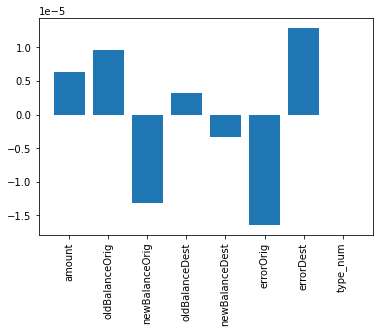

In [43]:
importance = logreg_model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d - %s, Score: %.6f' % (i,columns[i],v))

# plot feature importance
plt.bar([columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

# Let's Predict

In [44]:
# predict against X_test
y_pred = logreg_model.predict(X_test)
y_pred

array([1, 0, 1, ..., 0, 1, 1])

In [45]:
# Let's save our results in a variable for later use
y_pred_lr = y_pred

# How did our logistic regression perform?

print("accuracy: ",accuracy_score(y_test,y_pred_lr))
print("precision_score: ",precision_score(y_test,y_pred_lr))
print("recall_score: ",recall_score(y_test,y_pred_lr))
print("confusion matrix: ")
confusion_matrix(y_test,y_pred_lr)

accuracy:  0.8331483786190427
precision_score:  0.7571594427244582
recall_score:  0.9809846486282366
confusion matrix: 


array([[1306085,  599890],
       [  36256, 1870414]])

Note:

A logistic model with no over sampling resulted in these stats:

accuracy:  0.9982868692456881
precision_score:  0.35251299826689775
recall_score:  0.4204216618437371
confusion matrix: 
array([[1904499,    1868],
       [   1402,    1017]]

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.833


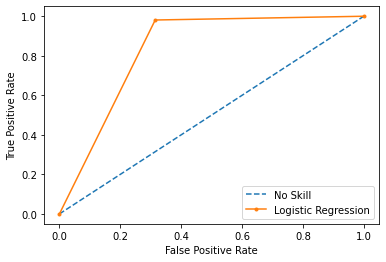

In [46]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = y_pred_lr
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Neural Network

As our base model we will use a simple logistic regression as our starting point for developing our predictive model.

In [47]:
%%time 

# Class MLPClassifier implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation.



nn_model = MLPClassifier(random_state=0)

nn_model.fit(X_train, y_train)


CPU times: user 18min 3s, sys: 39min 37s, total: 57min 40s
Wall time: 11min 10s


MLPClassifier(random_state=0)

In [48]:
# predict against X_test
y_pred = nn_model.predict(X_test)
y_pred

array([1, 0, 1, ..., 0, 0, 1])

In [49]:
# Let's save our results in a variable for later use
y_pred_nn = y_pred

# How did our neural network model perform?

print("accuracy: ",accuracy_score(y_test,y_pred_nn))
print("precision_score: ",precision_score(y_test,y_pred_nn))
print("recall_score: ",recall_score(y_test,y_pred_nn))
print("confusion matrix: ")
confusion_matrix(y_test,y_pred_nn)

accuracy:  0.9519150091340788
precision_score:  0.9997726380310453
recall_score:  0.9040531397672382
confusion matrix: 


array([[1905583,     392],
       [ 182939, 1723731]])

Neural Network without oversampling:

accuracy:  0.9994981103172383
precision_score:  0.8158236057068742
recall_score:  0.7800744109136006
confusion matrix: 
array([[1905941,     426],
       [    532,    1887]]

No Skill: ROC AUC=0.500
Neural Network: ROC AUC=0.952


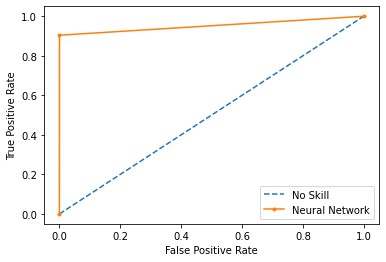

In [50]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = y_pred_nn

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Neural Network: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Revised Neural Network
Let's remodel the Neural Network but this time, let's filter out oldBalanceDest, newBalanceDest, and type_num since based on the feature importance review, these features contributed least to the predicting factor of the model.

In [51]:
# Let's remove the features and create our revised train test dataset
revised_X = X.drop(['oldBalanceDest','newBalanceDest','type_num'], axis=1)
revised_X_train, revised_X_test, y_train, y_test = train_test_split(revised_X, y, test_size=0.3, random_state=0)

In [52]:
%%time 

# Class MLPClassifier implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation.



revised_nn_model = MLPClassifier(random_state=0)

revised_nn_model.fit(revised_X_train, y_train)


CPU times: user 16min 4s, sys: 36min 40s, total: 52min 45s
Wall time: 9min 45s


MLPClassifier(random_state=0)

In [53]:
# predict against X_test
y_pred = revised_nn_model.predict(revised_X_test)
y_pred

array([1, 0, 1, ..., 0, 0, 1])

In [54]:
# Let's save our results in a variable for later use
y_pred_revised_nn = y_pred

# How did our neural network model perform?

print("accuracy: ",accuracy_score(y_test,y_pred_revised_nn))
print("precision_score: ",precision_score(y_test,y_pred_revised_nn))
print("recall_score: ",recall_score(y_test,y_pred_revised_nn))
print("confusion matrix: ")
confusion_matrix(y_test,y_pred_revised_nn)

accuracy:  0.9866355246816843
precision_score:  0.9997796970052797
recall_score:  0.973490430960785
confusion matrix: 


array([[1905566,     409],
       [  50545, 1856125]])

No Skill: ROC AUC=0.500
Neural Network: ROC AUC=0.987


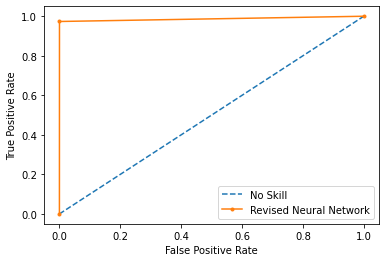

In [55]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = y_pred_revised_nn

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Neural Network: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Revised Neural Network')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Let's summarize our findings:

In [56]:
tmp_list = []
tmp_dict = {"accuracy":accuracy_score(y_test,y_pred_lr), "precision":precision_score(y_test,y_pred_lr), "recall":recall_score(y_test,y_pred_lr),"roc auc": roc_auc_score(y_test,y_pred_lr)}
tmp_list.append(tmp_dict)
tmp_dict = {"accuracy":accuracy_score(y_test,y_pred_nn), "precision":precision_score(y_test,y_pred_nn), "recall":recall_score(y_test,y_pred_nn),"roc auc":roc_auc_score(y_test,y_pred_nn)}
tmp_list.append(tmp_dict)
tmp_dict = {"accuracy":accuracy_score(y_test,y_pred_revised_nn), "precision":precision_score(y_test,y_pred_revised_nn), "recall":recall_score(y_test,y_pred_revised_nn),"roc auc":roc_auc_score(y_test,y_pred_revised_nn)}
tmp_list.append(tmp_dict)

scores_df = pd.DataFrame(tmp_list)
scores_df.index = ['LogisticRegression','NeuralNetworks','RevisedNeuralNetworks']
scores_df

,accuracy,precision,recall,roc auc
LogisticRegression,0.833148,0.757159,0.980985,0.833121
NeuralNetworks,0.951915,0.999773,0.904053,0.951924
RevisedNeuralNetworks,0.986636,0.999780,0.973490,0.986638


## How do we choose our champion model? IT DEPENDS

Fraud use cases are a tricky challenge to tackle given its nature of being inherently 'hidden'. It always implies that the dataset would always be imbalanced and that we would never have the complete picture of all the possible fraud indicators and that everytime we catch fraudsters they will inevitably change behavior to find other fraudulent techniques that have not yet been detected.

Its important to be anchored on the objective of the business and how it is affected by fraud. Depending on  the type of industry, a business may be affected by the cost of a fraud transactions, the cost of investigating a fraud case, the cost to entity's reputation, or the cost to the customer experience. Looking at all these factors will help one decide which model is based used that greatly cater's to the business need.

Given our curret use case, we **recommend the 2nd model (In this case, Neural Network)** which has a high precision as we have a high volume transactional business which means when investigating fraudulent activities, we want to limit the capture of false positives to control the cost of investigating fraud (which is normally high) and to minimize the impact to our customers (its annoying to be accused of fraud if you are actually a legit customer and have your transactions frozen).

## Cumulative Accuracy Profile (CAP) or Lorenz Curve

CAP popularly called the ‘Cumulative Accuracy Profile’ is used in the performance evaluation of the classification model. It helps us to understand and conclude about the robustness of the classification model. 

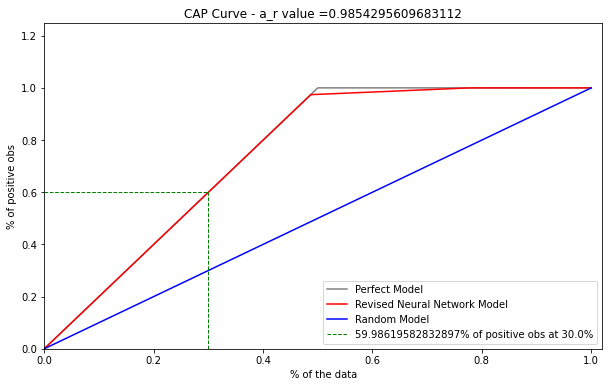

In [57]:


def capcurve(y_values, y_preds_proba):
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)
    
    y_cap = np.c_[y_values,y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index(level = y_cap_df_s.index.names, drop=True)
    
    #print(y_cap_df_s.head(20))
    
    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0
    
    percent = 0.3
    row_index = int(np.trunc(num_count * percent))
    
    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)
    
    sigma_ideal = 1 * xx[num_pos_obs - 1 ] / 2 + (xx[num_count - 1] - xx[num_pos_obs]) * 1
    sigma_model = integrate.simps(yy,xx)
    sigma_random = integrate.simps(xx,xx)
    
    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.subplots(nrows = 1, ncols = 1)

    
    ax.plot(ideal['x'],ideal['y'], color='grey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label='Revised Neural Network Model')
    ax.plot(xx,xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label=str(val*100)+'% of positive obs at '+str(percent*100)+'%')
    
    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve - a_r value ="+str(ar_value))
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()
    plt.show()

    
# Let's store the pred probability for use later when we call the CAP function
revised_y_pred_proba = revised_nn_model.predict_proba(X=revised_X_test)

# Let's cal lthe cap curve function. What does this is pass the y_test (which contains our target classification
# as well as the predicted probabilities. The intention is to chart our CAP and see what is the optimal approach to 
# acting on our scored transaction list 
capcurve(y_test,revised_y_pred_proba[:,1])

The chart tells us that if we only investigate the top 50% of the scored transaction list, we will already get 97.56% of all fraudulent cases.

In [58]:
# Let's create our white list. This white list will be the list of transactions that we will spend resources to investigate
# as they are the most probable fraud cases based on our revised neural network model

save_whitelist_df = revised_X_test.copy() # Let's create a dataframe of the test dataset
save_whitelist_df['y_pred_proba'] = revised_y_pred_proba[:,1] # store the probability to be a fraud case
save_whitelist_df['y_pred'] = y_pred_nn # add the predictions of our revised neural network
save_whitelist_df = save_whitelist_df.sort_values('y_pred_proba',ascending=False) # sort with highest to lowest probability

In [59]:
# Let's get our cut off and filter to the final list and save to a CSV File

percentage = .49 # Let's use 49% since based on the chart we already hit the optimal cutoff before 50%
cutoff = int(save_whitelist_df.shape[0]*percentage) # will get the absolute count of 49% of total rows
print("Our cutoff value is ", cutoff)
save_whitelist_df = save_whitelist_df[0:cutoff] # we filter until the cutoff
save_whitelist_df.to_csv("fraud_revised_nn.csv") # Filter only to the predcted and save our CSV file
print("We predict ",save_whitelist_df['y_pred'].sum(), " fraud cases out of ", revised_X_test.shape[0], " transactions.")
save_whitelist_df.head()

Our cutoff value is  1868196
We predict  1719309  fraud cases out of  3812645  transactions.


,amount,oldBalanceOrig,newBalanceOrig,errorOrig,errorDest,y_pred_proba,y_pred
12509874,118109.796090,118109.796090,0.000000,0.000000,118109.796090,1.000000,1
8129197,1092656.237901,1092656.237901,0.000000,0.000000,1092656.237901,1.000000,1
10113242,418265.096979,418265.096979,0.000000,0.000000,0.000000,1.000000,1
7013276,450665.434085,450665.434085,0.000000,0.000000,450665.434085,1.000000,1
9541005,100976.926606,100976.926606,0.000000,0.000000,100976.926606,1.000000,1



## Dataset to try
- https://www.kaggle.com/c/ieee-fraud-detection

## Other references

https://github.com/dheerajsuvarna/Social-Network-Analysis

https://trenton3983.github.io/files/projects/2019-07-19_fraud_detection_python/2019-07-19_fraud_detection_python.html

https://christophm.github.io/interpretable-ml-book/


## Advanced Reading

https://towardsdatascience.com/an-introduction-to-graph-neural-network-gnn-for-analysing-structured-data-afce79f4cfdc
https://github.com/safe-graph/graph-fraud-detection-papers
